# Edge Detection Using U-Net Architecture

### Reference

- https://github.com/usuyama/pytorch-unet
- https://github.com/milesial/Pytorch-UNet


## Preprocessing

In [1]:
import cv2
import matplotlib.pyplot as plt
import scipy.io
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import ndimage, misc
from sklearn.metrics import average_precision_score

In [2]:
folder = 'BSR_unzip/BSR/BSDS500/data/'

def load_images(folder):
    images = []
    files = os.listdir(folder)
    files = [i for i in files if '.jpg' in i]
    files.sort()
    for filename in files:
        img = cv2.imread(os.path.join(folder,filename))
        if img.shape == (481, 321, 3):
            img = np.transpose(img, (1, 0, 2)) 
        ## do padding
        #img = np.pad(img, ((0, 1), (0, 1), (0, 0)), mode='constant', constant_values=0)
        # do cropping
        img = img[:320, :480, :]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

def load_labels(folder):
    labels = []
    files = os.listdir(folder)
    files.sort()
    for filename in files:
        gts_len = len((scipy.io.loadmat(os.path.join(folder,filename)))['groundTruth'][0])
        gt_majority = np.zeros((scipy.io.loadmat(os.path.join(folder,filename)))['groundTruth'][0][0][0][0][1].shape)
        for i in range(gts_len):
            label = (scipy.io.loadmat(os.path.join(folder,filename)))['groundTruth'][0][i][0][0][1]
            label = np.where(label == 0, -1, 1)
            gt_majority += label
        gt_majority = np.where(gt_majority >= -1, 1, 0)
        if gt_majority.shape == (481, 321):
            gt_majority = gt_majority.T
        ## do padding
        #gt_majority = np.pad(gt_majority, ((0, 1), (0, 1)), mode='constant', constant_values=0)
        # do cropping
        gt_majority = gt_majority[:320, :480]
        labels.append(gt_majority)
            
    return labels

# Load Images
xtrain_org = load_images(folder + 'images/train')
xtest = load_images(folder + 'images/test')
xval_org = load_images(folder + 'images/val')

# Load Ground Truths Using Majority Vote Notion
ytrain_org = load_labels(folder + 'groundTruth/train')
ytest = load_labels(folder + 'groundTruth/test')
yval_org = load_labels(folder + 'groundTruth/val')

#plt.imshow(xtrain[0])
#plt.imshow(ytrain[0])
#
#plt.imshow(xtrain[1])
#plt.imshow(ytrain[1])

In [3]:
## Populate images by rotating (Image augmentation)

def augment_image(img_list, split = 8):
    my_list = []
    for i in range(len(img_list)):
        for j in range(split):
            my_list.append(ndimage.rotate(img_list[i], angle=j*(360/split), reshape=False))
    return my_list

In [4]:
# This takes a while
xtrain = augment_image(xtrain_org)
xval = augment_image(xval_org)

ytrain = augment_image(ytrain_org)
yval = augment_image(yval_org)

In [5]:
del xtrain_org, xval_org, ytrain_org, yval_org

In [6]:
#pickle.dump((xtrain, xtest, xval, ytrain, ytest, yval), open( "save.p", "wb" ) )

## Load Preprocessed Data

In [7]:
# Data for U-Net
#(xtrain, xtest, xval, ytrain, ytest, yval) = pickle.load(open("save.p","rb"))

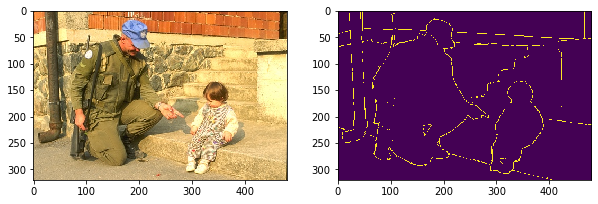

In [3]:
plt.subplots(1,2,figsize=(10,10))

index = 448

plt.subplot(1, 2, 1)
plt.imshow(xtrain[index])

plt.subplot(1, 2, 2)
plt.imshow(ytrain[index])

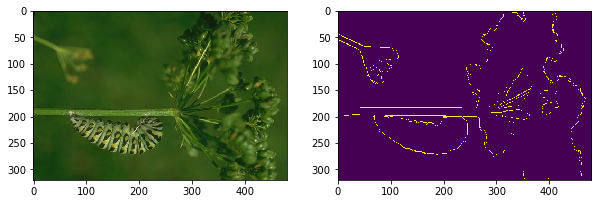

In [4]:
plt.subplots(1,2,figsize=(10,10))

index = 150

plt.subplot(1, 2, 1)
plt.imshow(xtest[index])

plt.subplot(1, 2, 2)
plt.imshow(ytest[index])

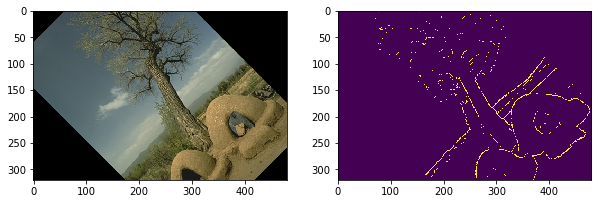

In [5]:
plt.subplots(1,2,figsize=(10,10))

index = 655

plt.subplot(1, 2, 1)
plt.imshow(xval[index])

plt.subplot(1, 2, 2)
plt.imshow(yval[index])

In [6]:
# Stack images along a new axis

xtrain = np.vstack([i[None, :, :, :] for i in xtrain])
xtest = np.vstack([i[None, :, :, :] for i in xtest])
xval = np.vstack([i[None, :, :, :] for i in xval])

xtrain.shape, xtest.shape, xval.shape

((1600, 320, 480, 3), (200, 320, 480, 3), (800, 320, 480, 3))

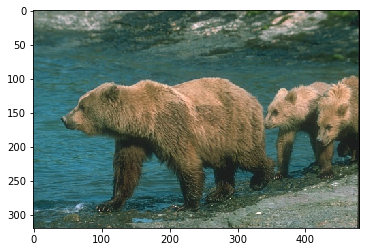

In [7]:
plt.imshow(xtrain[0, :, :, :])

In [8]:
# Stack labels along a new axis

ytrain = np.vstack([i[None, :, :] for i in ytrain])
ytest = np.vstack([i[None, :, :] for i in ytest])
yval = np.vstack([i[None, :, :] for i in yval])

ytrain.shape, ytest.shape, yval.shape

((1600, 320, 480), (200, 320, 480), (800, 320, 480))

In [9]:
## Create tensors from images
import torch

xtrain = torch.from_numpy(np.transpose(xtrain, [0, 3, 1, 2]))
xtest = torch.from_numpy(np.transpose(xtest, [0, 3, 1, 2]))
xval = torch.from_numpy(np.transpose(xval, [0, 3, 1, 2]))

xtrain.shape, xtest.shape, xval.shape

(torch.Size([1600, 3, 320, 480]),
 torch.Size([200, 3, 320, 480]),
 torch.Size([800, 3, 320, 480]))

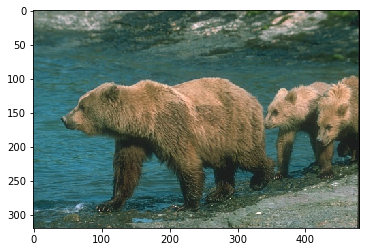

In [10]:
plt.imshow(np.transpose(xtrain.numpy()[0, :, :, :], [1, 2, 0]))

In [11]:
## Create tensors from labels
ytrain = torch.from_numpy(ytrain).view(len(ytrain), 1, 320, 480)
ytest = torch.from_numpy(ytest).view(len(ytest), 1, 320, 480)
yval = torch.from_numpy(yval).view(len(yval), 1, 320, 480)

ytrain.shape, ytest.shape, yval.shape

(torch.Size([1600, 1, 320, 480]),
 torch.Size([200, 1, 320, 480]),
 torch.Size([800, 1, 320, 480]))

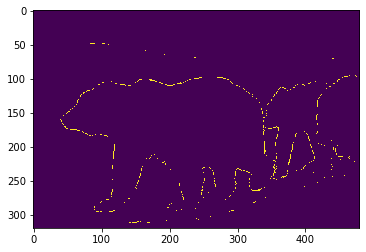

In [12]:
plt.imshow(ytrain[0,0,:,:])

In [13]:
# change data types
xtrain = xtrain.type('torch.FloatTensor')
xtest = xtest.type('torch.FloatTensor')
xval = xval.type('torch.FloatTensor')

ytrain = ytrain.type('torch.FloatTensor')
ytest = ytest.type('torch.FloatTensor')
yval = yval.type('torch.FloatTensor')

In [14]:
# Adjust data, make it usable for dataloader
train_set = [[xtrain[i, :, :, :], ytrain[i, :, :]] for i in range(xtrain.shape[0])]
test_set = [[xtest[i, :, :, :], ytest[i, :, :]] for i in range(xtest.shape[0])]
val_set = [[xval[i, :, :, :], yval[i, :, :]] for i in range(xval.shape[0])]

In [15]:
train_set[0][0].shape, train_set[0][1].shape

(torch.Size([3, 320, 480]), torch.Size([1, 320, 480]))

In [16]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 4

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 1600, 'val': 800}

In [17]:
del xtrain, xval, ytrain, yval

## Training

In [18]:
# Define U-net Model

import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        #out = torch.sigmoid(out)
        
        return out

In [19]:
from torchsummary import summary
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(1)
model = model.to(device)

summary(model, input_size=(3, 320, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 480]           1,792
              ReLU-2         [-1, 64, 320, 480]               0
            Conv2d-3         [-1, 64, 320, 480]          36,928
              ReLU-4         [-1, 64, 320, 480]               0
         MaxPool2d-5         [-1, 64, 160, 240]               0
            Conv2d-6        [-1, 128, 160, 240]          73,856
              ReLU-7        [-1, 128, 160, 240]               0
            Conv2d-8        [-1, 128, 160, 240]         147,584
              ReLU-9        [-1, 128, 160, 240]               0
        MaxPool2d-10         [-1, 128, 80, 120]               0
           Conv2d-11         [-1, 256, 80, 120]         295,168
             ReLU-12         [-1, 256, 80, 120]               0
           Conv2d-13         [-1, 256, 80, 120]         590,080
             ReLU-14         [-1, 256, 

In [20]:
from collections import defaultdict
import torch.nn.functional as F

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            
            if phase == 'val':
                val_losses.append(epoch_loss)
            else:
                train_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, best_loss

In [26]:
### tune for the best param set
#import torch
#import torch.optim as optim
#from torch.optim import lr_scheduler
#import time
#import copy
#
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
#num_class = 1
#
#lr_list = [1e-3, 1e-4, 1e-5]
#optimi_list = ['adam']
#step_list = [10, 20]
#gamma_list = [0.5, 0.1]
#momentum_list = [0]
#
#loss_init = 10**8
#
#for lr in lr_list:
#    for optimi in optimi_list:
#        for step in step_list:
#            for gamma in gamma_list:
#                for momentum in momentum_list:
#                    model = UNet(num_class).to(device)
#                    # Observe that all parameters are being optimized
#                    if optimi == 'adam':
#                        optimizer_ft = optim.Adam(model.parameters(), lr=lr)
#                        if momentum > 0.00000001:
#                            continue
#                    if optimi == 'sgd':
#                        optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
#    
#                    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step, gamma=gamma)
#                    
#                    print({'lr':lr, 'optimi':optimi, 'step':step, 'gamma':gamma, 'momentum': momentum})
#                    model_step, train_losses_step, val_losses_step, best_loss_step = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)
#                    
#                    if best_loss_step < loss_init:
#                        model, train_losses, val_losses, best_loss = model_step, train_losses_step, val_losses_step, best_loss_step
#                        params = {'lr':lr, 'optimi':optimi, 'step':step, 'gamma':gamma, 'momentum': momentum}
#                        loss_init = best_loss_step

In [27]:
#pickle.dump((model, train_losses, val_losses, best_loss, params), open( "model.p", "wb" ) )

In [28]:
#params
#{'lr': 0.0001, 'optimi': 'adam', 'step': 10, 'gamma': 0.1, 'momentum': 0}

In [29]:
#print(best_loss)
#0.4133796137198806

In [21]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

model, train_losses, val_losses, best_loss = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------


/home/iocak/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/iocak/.local/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


LR 0.0001
train: bce: 0.100098, dice: 0.905407, loss: 0.502753
val: bce: 0.080741, dice: 0.834356, loss: 0.457548
saving best model
1m 52s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.084570, dice: 0.812920, loss: 0.448745
val: bce: 0.080979, dice: 0.795603, loss: 0.438291
saving best model
1m 53s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.082924, dice: 0.789102, loss: 0.436013
val: bce: 0.080481, dice: 0.785750, loss: 0.433115
saving best model
1m 53s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.081826, dice: 0.772974, loss: 0.427400
val: bce: 0.077812, dice: 0.780678, loss: 0.429245
saving best model
1m 53s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.080882, dice: 0.761761, loss: 0.421321
val: bce: 0.082947, dice: 0.768107, loss: 0.425527
saving best model
1m 53s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.080312, dice: 0.754785, loss: 0.417549
val: bce: 0.081612, dice: 0.767615, loss: 0.424613
saving best model
1m 53s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.079960, di

In [108]:
#pickle.dump(model, open( "last_model.p", "wb" ) )

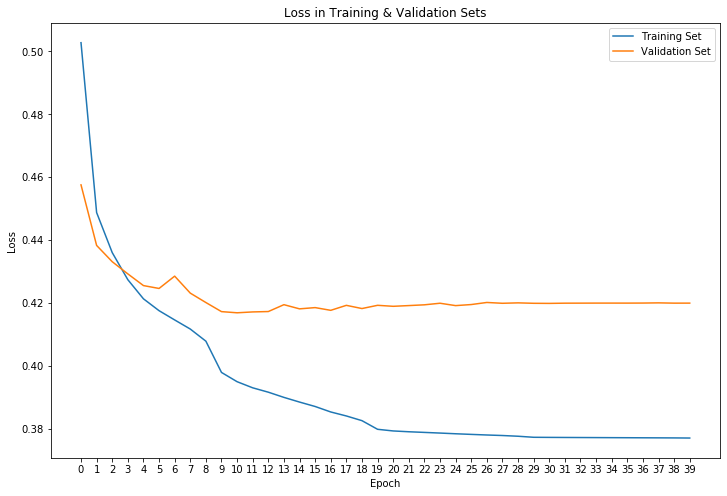

In [25]:
# plot train vs validation set error

plt.figure(figsize=(12,8))
plt.plot(range(len(train_losses)), train_losses, label = 'Training Set')
plt.plot(range(len(val_losses)), val_losses, label = 'Validation Set')
plt.xticks(range(len(val_losses)))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss in Training & Validation Sets')
plt.show()

## Prediction

In [26]:
# prediction for 1 instance

import math

model.eval()   # Set model to evaluate mode

test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
pred = pred[0, 0, :, :]
pred_prob = pred.copy()
pred = np.where(pred>=0.5, 1, 0)

gt = ytest.numpy()[0, 0, :, :]

org = np.transpose(xtest.numpy()[0, :, :, :], [1, 2, 0]).astype(int)

In [27]:
# accuracy
accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

# precision
tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
precision = tp / (tp + fp)

# recall
fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
recall = tp / (tp + fn)

# f-value
fvalue = 2 * precision * recall / (precision + recall)

# mean Average Precision
m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred_prob.reshape(-1))

In [28]:
print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')

Accuracy: 0.9733, Precision: 0.3063, Recall: 0.3711, F-value: 0.3356, m-AP: 0.2506


Text(0.5, 1.0, 'Pred')

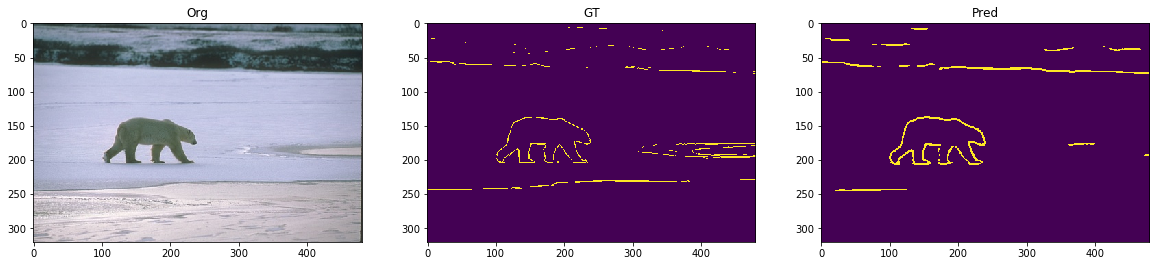

In [29]:
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org)
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt)
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(pred)
plt.title('Pred')

In [30]:
num_it = len(test_set)

model.eval()   # Set model to evaluate mode

test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
iterator = iter(test_loader)

org_list = []
gt_list = []
pred_list = []
accuracy_list = []
precision_list = []
recall_list = []
fvalue_list = []
map_list = []

for i in range(num_it):
    inputs, labels = next(iterator)
    inputs = inputs.to(device)
    labels = labels.to(device)

    pred = model(inputs)
    pred = torch.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    pred = pred[0, 0, :, :]
    
    # arrays
    pred_prob = pred.copy()
    pred = np.where(pred>=0.5, 1, 0)
    gt = ytest.numpy()[i, 0, :, :]
    org = np.transpose(xtest.numpy()[i, :, :, :], [1, 2, 0]).astype(int)
    
    # metrics
    # accuracy
    accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

    # precision
    tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
    fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
    precision = tp / (tp + fp)

    # recall
    fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
    recall = tp / (tp + fn)

    # f-value
    if (precision == 0) & (recall == 0):
        fvalue = 0
    else:
        fvalue = 2 * precision * recall / (precision + recall)
        
    # mean Average Precision
    m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred_prob.reshape(-1))
    
    print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')
    
    org_list.append(org)
    gt_list.append(gt)
    pred_list.append(pred)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fvalue_list.append(fvalue)
    map_list.append(m_ap)

Accuracy: 0.9733, Precision: 0.3063, Recall: 0.3711, F-value: 0.3356, m-AP: 0.2506
Accuracy: 0.976, Precision: 0.257, Recall: 0.3292, F-value: 0.2886, m-AP: 0.2168
Accuracy: 0.982, Precision: 0.236, Recall: 0.1904, F-value: 0.2108, m-AP: 0.1827
Accuracy: 0.9594, Precision: 0.1759, Recall: 0.5293, F-value: 0.2641, m-AP: 0.203
Accuracy: 0.9789, Precision: 0.3001, Recall: 0.2966, F-value: 0.2984, m-AP: 0.1981
Accuracy: 0.962, Precision: 0.2038, Recall: 0.6377, F-value: 0.3089, m-AP: 0.2026
Accuracy: 0.9646, Precision: 0.2088, Recall: 0.2165, F-value: 0.2126, m-AP: 0.1525
Accuracy: 0.9691, Precision: 0.1504, Recall: 0.4692, F-value: 0.2278, m-AP: 0.1605
Accuracy: 0.985, Precision: 0.2135, Recall: 0.4965, F-value: 0.2986, m-AP: 0.2229
Accuracy: 0.9706, Precision: 0.2764, Recall: 0.2661, F-value: 0.2711, m-AP: 0.1989
Accuracy: 0.9798, Precision: 0.0722, Recall: 0.0359, F-value: 0.0479, m-AP: 0.0495
Accuracy: 0.975, Precision: 0.1959, Recall: 0.4635, F-value: 0.2754, m-AP: 0.2137
Accuracy: 0.

In [31]:
metrics = pd.DataFrame({'accuracy' : accuracy_list,
                        'precision' : precision_list,
                        'recall' : recall_list,
                        'fscore' : fvalue_list,
                        'mAP' : map_list})

In [32]:
metrics.mean()

accuracy     0.966533
precision    0.224737
recall       0.364325
fscore       0.260864
mAP          0.186041
dtype: float64

Text(0.5, 1.0, 'Pred')

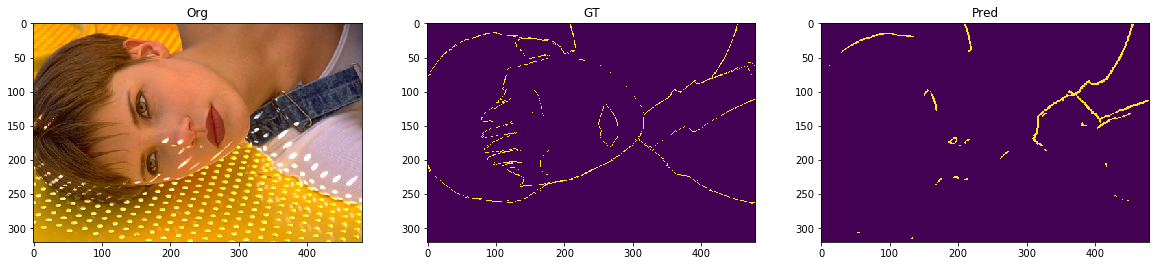

In [458]:
# Inspect some images
index = 161
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(pred_list[index])
plt.title('Pred')

Text(0.5, 1.0, 'Pred')

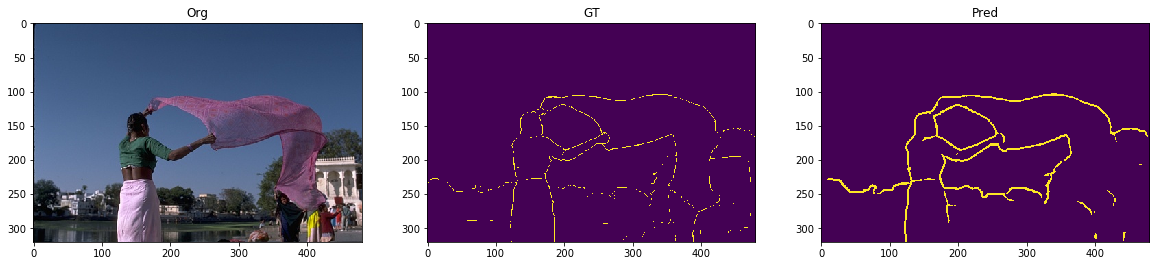

In [270]:
# Inspect some images
index = 190
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(pred_list[index])
plt.title('Pred')

Text(0.5, 1.0, 'Pred')

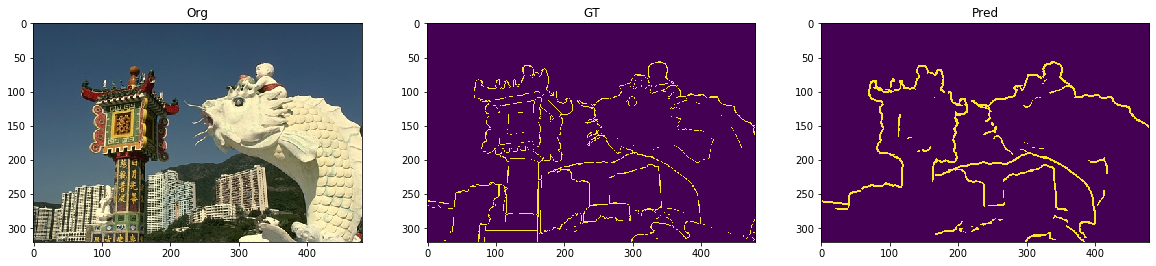

In [62]:
# Inspect some images
index = 29
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(pred_list[index])
plt.title('Pred')

Text(0.5, 1.0, 'Pred')

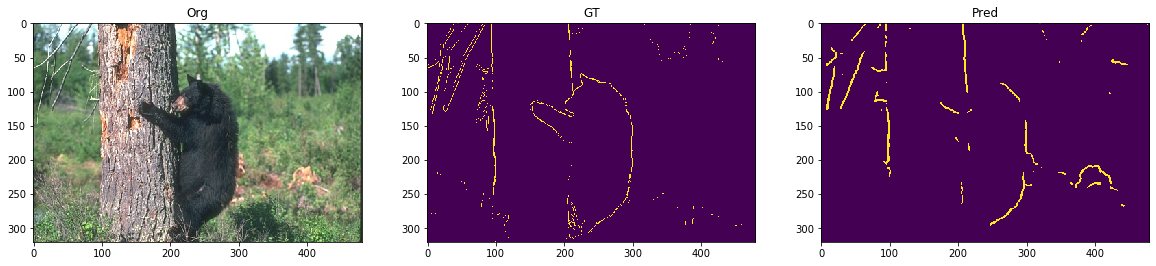

In [82]:
# Inspect some images
index = 1
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(pred_list[index])
plt.title('Pred')

In [83]:
del train_set, val_set

## Alternative Methods for Comparison

## Canny

In [84]:
canny_predictions = []
for i in range(len(xtest.numpy())):
    img = np.transpose(xtest.numpy()[i, :, :, :], [1, 2, 0]).astype(np.uint8)
    canny_predictions.append(cv2.Canny(img,200,300) / 255)

In [85]:
accuracy_list = []
precision_list = []
recall_list = []
fvalue_list = []
map_list = []

for i in range(len(xtest.numpy())):
    pred = canny_predictions[i]
    gt = ytest.numpy()[i, 0, :, :]
    
    # metrics
    # accuracy
    accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

    # precision
    tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
    fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
    precision = tp / (tp + fp)

    # recall
    fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
    recall = tp / (tp + fn)

    # f-value
    if (precision == 0) & (recall == 0):
        fvalue = 0
    else:
        fvalue = 2 * precision * recall / (precision + recall)
    
# mean Average Precision
    m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred.reshape(-1))
    
    print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fvalue_list.append(fvalue)
    map_list.append(m_ap)

Accuracy: 0.9708, Precision: 0.243, Recall: 0.2889, F-value: 0.264, m-AP: 0.0831
Accuracy: 0.8513, Precision: 0.0296, Recall: 0.2856, F-value: 0.0537, m-AP: 0.019
Accuracy: 0.9784, Precision: 0.0659, Recall: 0.0535, F-value: 0.0591, m-AP: 0.0155
Accuracy: 0.9457, Precision: 0.0508, Recall: 0.1665, F-value: 0.0778, m-AP: 0.0199
Accuracy: 0.8865, Precision: 0.0312, Recall: 0.2163, F-value: 0.0545, m-AP: 0.0186
Accuracy: 0.838, Precision: 0.0366, Recall: 0.4411, F-value: 0.0676, m-AP: 0.0236
Accuracy: 0.8295, Precision: 0.0317, Recall: 0.228, F-value: 0.0557, m-AP: 0.0243
Accuracy: 0.8679, Precision: 0.019, Recall: 0.2483, F-value: 0.0353, m-AP: 0.012
Accuracy: 0.9857, Precision: 0.1039, Recall: 0.1608, F-value: 0.1262, m-AP: 0.0221
Accuracy: 0.9224, Precision: 0.0842, Recall: 0.282, F-value: 0.1297, m-AP: 0.0385
Accuracy: 0.9269, Precision: 0.0451, Recall: 0.2064, F-value: 0.0741, m-AP: 0.0206
Accuracy: 0.9735, Precision: 0.1089, Recall: 0.22, F-value: 0.1457, m-AP: 0.032
Accuracy: 0.955

In [86]:
metrics = pd.DataFrame({'accuracy' : accuracy_list,
                        'precision' : precision_list,
                        'recall' : recall_list,
                        'fscore' : fvalue_list,
                        'mAP' : map_list})

In [87]:
metrics.mean()

accuracy     0.914372
precision    0.072031
recall       0.239092
fscore       0.101855
mAP          0.031292
dtype: float64

Text(0.5, 1.0, 'Pred')

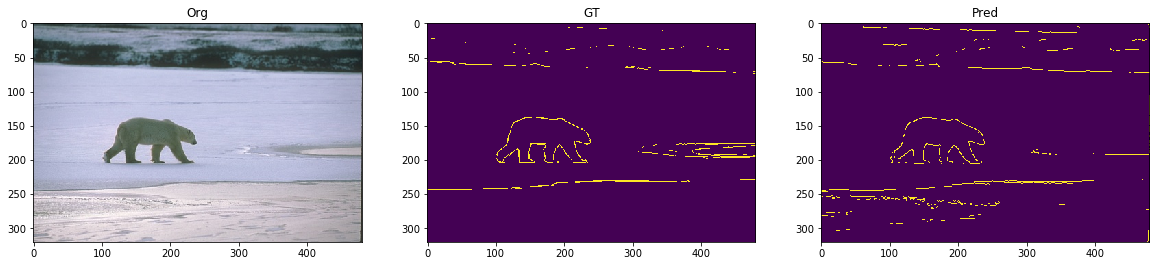

In [88]:
# Inspect some images
index = 0
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(canny_predictions[index])
plt.title('Pred')

Text(0.5, 1.0, 'Pred')

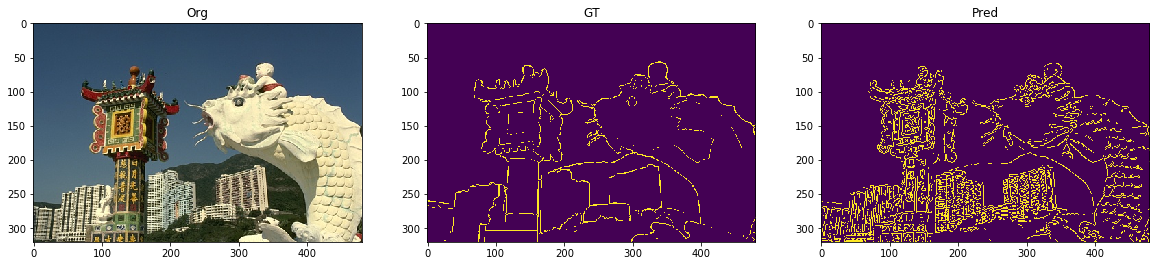

In [90]:
# Inspect some images
index = 29
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(canny_predictions[index])
plt.title('Pred')

Text(0.5, 1.0, 'Pred')

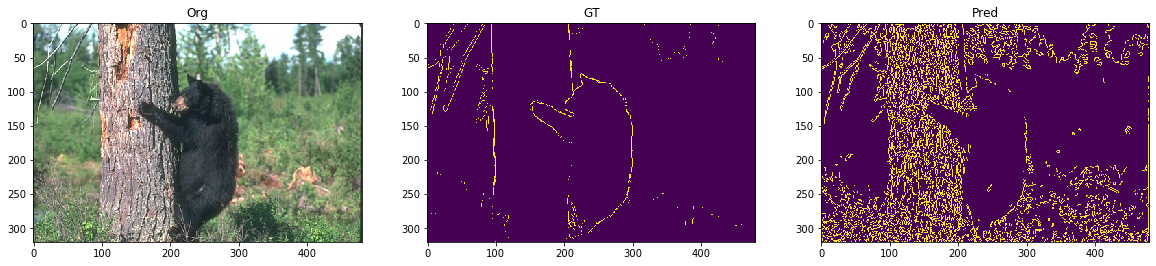

In [91]:
# Inspect some images
index = 1
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(canny_predictions[index])
plt.title('Pred')

## Sobel

In [92]:
sobel_predictions = [];
for i in range(len(xtest.numpy())):
    img = np.transpose(xtest.numpy()[i, :, :, :], [1, 2, 0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    grad_x = cv2.Sobel(img, cv2.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(img, cv2.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    (thresh, grad) = cv2.threshold(grad, 127, 255, cv2.THRESH_BINARY)
    
    sobel_predictions.append(grad)

In [93]:
accuracy_list = []
precision_list = []
recall_list = []
fvalue_list = []
map_list = []

for i in range(len(xtest.numpy())):
    pred = sobel_predictions[i]
    gt = ytest.numpy()[i, 0, :, :]
    
    pred_prob = pred.copy()
    pred = np.where(pred>=0.5, 1, 0)
    
    # metrics
    # accuracy
    accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

    # precision
    tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
    fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
    precision = tp / (tp + fp)

    # recall
    fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
    recall = tp / (tp + fn)

    # f-value
    if (precision == 0) & (recall == 0):
        fvalue = 0
    else:
        fvalue = 2 * precision * recall / (precision + recall)
        
    # mean Average Precision
    m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred_prob.reshape(-1))
    
    print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fvalue_list.append(fvalue)
    map_list.append(m_ap)

Accuracy: 0.9772, Precision: 0.2296, Recall: 0.108, F-value: 0.1469, m-AP: 0.041
Accuracy: 0.7887, Precision: 0.0311, Recall: 0.4412, F-value: 0.0581, m-AP: 0.022
Accuracy: 0.9711, Precision: 0.0554, Recall: 0.0798, F-value: 0.0654, m-AP: 0.0161
Accuracy: 0.963, Precision: 0.0539, Recall: 0.1022, F-value: 0.0706, m-AP: 0.0179
Accuracy: 0.854, Precision: 0.0323, Recall: 0.2984, F-value: 0.0583, m-AP: 0.0203
Accuracy: 0.8445, Precision: 0.0368, Recall: 0.424, F-value: 0.0677, m-AP: 0.0233
Accuracy: 0.8036, Precision: 0.0328, Recall: 0.2775, F-value: 0.0587, m-AP: 0.0251
Accuracy: 0.8656, Precision: 0.0244, Recall: 0.3293, F-value: 0.0455, m-AP: 0.0146
Accuracy: 0.9855, Precision: 0.1179, Recall: 0.1941, F-value: 0.1467, m-AP: 0.0281
Accuracy: 0.9184, Precision: 0.0875, Recall: 0.3159, F-value: 0.1371, m-AP: 0.0417
Accuracy: 0.9584, Precision: 0.0576, Recall: 0.126, F-value: 0.079, m-AP: 0.0196
Accuracy: 0.9639, Precision: 0.0956, Recall: 0.2974, F-value: 0.1447, m-AP: 0.0356
Accuracy: 0.

In [94]:
metrics = pd.DataFrame({'accuracy' : accuracy_list,
                        'precision' : precision_list,
                        'recall' : recall_list,
                        'fscore' : fvalue_list,
                        'mAP' : map_list})

In [95]:
metrics.mean()

accuracy     0.903059
precision    0.069060
recall       0.270362
fscore       0.099477
mAP          0.032058
dtype: float64

Text(0.5, 1.0, 'Pred')

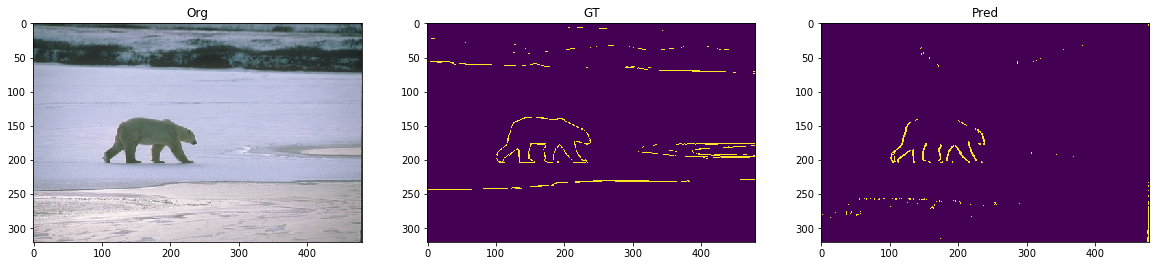

In [96]:
# Inspect some images
index = 0
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(sobel_predictions[index])
plt.title('Pred')

Text(0.5, 1.0, 'Pred')

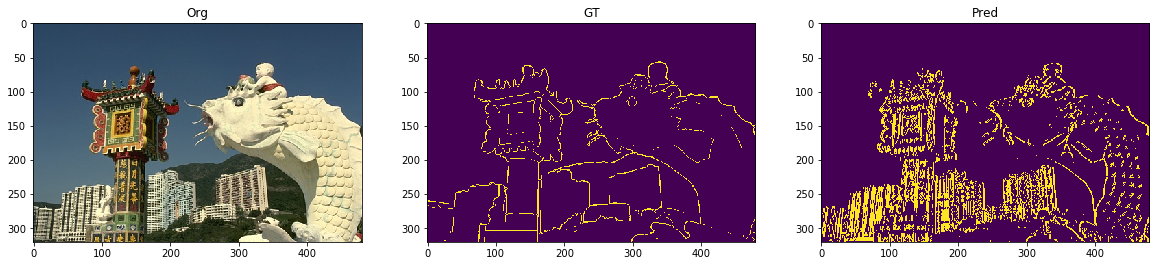

In [97]:
# Inspect some images
index = 29
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(sobel_predictions[index])
plt.title('Pred')

Text(0.5, 1.0, 'Pred')

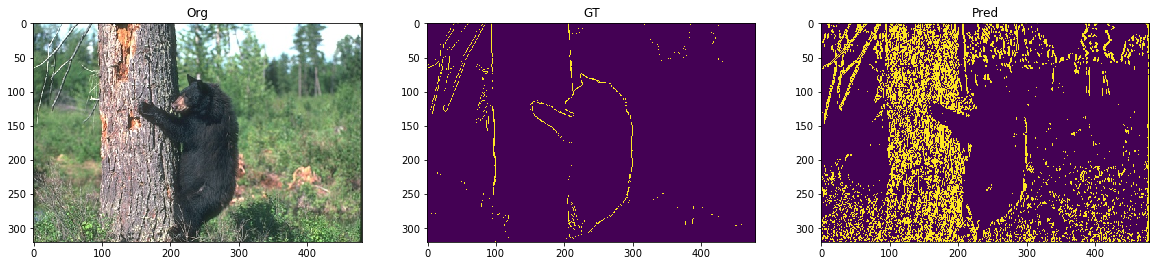

In [98]:
# Inspect some images
index = 1
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(sobel_predictions[index])
plt.title('Pred')

## HED

In [99]:
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

In [100]:
cv2.dnn_registerLayer('Crop', CropLayer)

# Load the model.
prototxt = 'deploy.prototxt.txt'
caffemodel = 'hed_pretrained_bsds.caffemodel'
net = cv2.dnn.readNet(prototxt,caffemodel)

In [101]:
hed_predictions = [];
for i in range(len(xtest.numpy())):
    img = np.transpose(xtest.numpy()[i, :, :, :], [1, 2, 0]).astype(np.uint8)
    inp = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(480,320),
                                mean=(104.00698793, 116.66876762, 122.67891434),
                                swapRB=False, crop=False)
    net.setInput(inp)
    out = net.forward()
    out = out[0, 0]
    hed_predictions.append(out)

In [102]:
accuracy_list = []
precision_list = []
recall_list = []
fvalue_list = []
map_list = []

for i in range(len(xtest.numpy())):
    pred = hed_predictions[i]
    gt = ytest.numpy()[i, 0, :, :]
    
    pred_prob = pred.copy()
    pred = np.where(pred>=0.5, 1, 0)
    
    hed_predictions[i] = pred
    
    # metrics
    # accuracy
    accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

    # precision
    tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
    fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
    precision = tp / (tp + fp)

    # recall
    fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
    recall = tp / (tp + fn)

    # f-value
    if (precision == 0) & (recall == 0):
        fvalue = 0
    else:
        fvalue = 2 * precision * recall / (precision + recall)
    
    # mean Average Precision
    m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred_prob.reshape(-1))
    
    print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fvalue_list.append(fvalue)
    map_list.append(m_ap)

Accuracy: 0.8887, Precision: 0.1265, Recall: 0.8697, F-value: 0.2209, m-AP: 0.2757
Accuracy: 0.8898, Precision: 0.0994, Recall: 0.8017, F-value: 0.1769, m-AP: 0.1936
Accuracy: 0.9246, Precision: 0.1097, Recall: 0.6979, F-value: 0.1896, m-AP: 0.1653
Accuracy: 0.8447, Precision: 0.0757, Recall: 0.9167, F-value: 0.1398, m-AP: 0.2101
Accuracy: 0.9331, Precision: 0.1466, Recall: 0.7094, F-value: 0.243, m-AP: 0.221
Accuracy: 0.8697, Precision: 0.0897, Recall: 0.9604, F-value: 0.164, m-AP: 0.2748
Accuracy: 0.8499, Precision: 0.1126, Recall: 0.8428, F-value: 0.1987, m-AP: 0.1847
Accuracy: 0.8714, Precision: 0.0569, Recall: 0.7845, F-value: 0.1061, m-AP: 0.1583
Accuracy: 0.9328, Precision: 0.0846, Recall: 0.9606, F-value: 0.1555, m-AP: 0.2341
Accuracy: 0.8823, Precision: 0.1294, Recall: 0.8271, F-value: 0.2238, m-AP: 0.2365
Accuracy: 0.819, Precision: 0.0579, Recall: 0.771, F-value: 0.1077, m-AP: 0.1018
Accuracy: 0.8869, Precision: 0.0787, Recall: 0.9347, F-value: 0.1451, m-AP: 0.165
Accuracy: 

In [103]:
metrics = pd.DataFrame({'accuracy' : accuracy_list,
                        'precision' : precision_list,
                        'recall' : recall_list,
                        'fscore' : fvalue_list,
                        'mAP' : map_list})

In [107]:
metrics.mean()

accuracy     0.861425
precision    0.099734
recall       0.825749
fscore       0.174998
mAP          0.188995
dtype: float64

Text(0.5, 1.0, 'Pred')

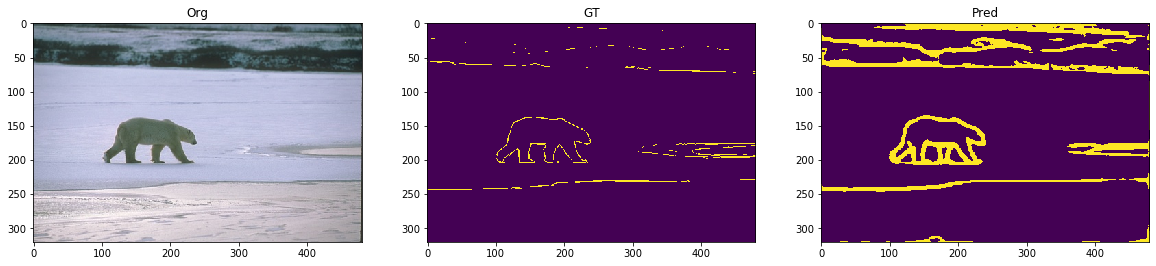

In [104]:
# Inspect some images
index = 0
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(hed_predictions[index])
plt.title('Pred')

Text(0.5, 1.0, 'Pred')

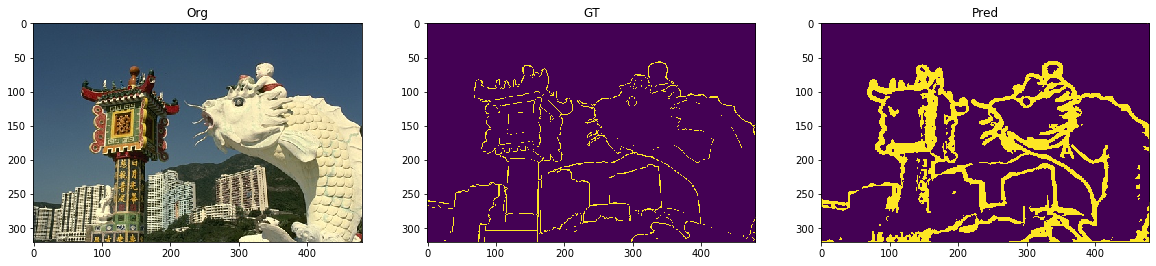

In [105]:
# Inspect some images
index = 29
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(hed_predictions[index])
plt.title('Pred')

Text(0.5, 1.0, 'Pred')

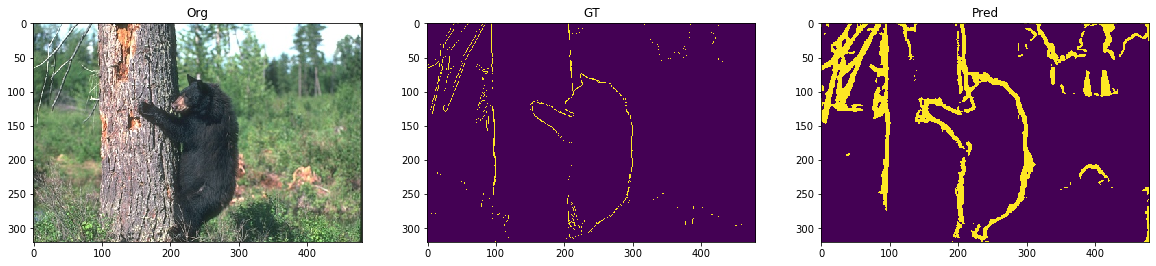

In [106]:
# Inspect some images
index = 1
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(hed_predictions[index])
plt.title('Pred')